In [260]:
import json
import os

results_dir = "results/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        print(f'Read fusion group {fusion_group} with {len(content)} lines')
        data.extend(content)

Read fusion group A.D.E,B,C,F,G with 102 lines
Read fusion group A,B,C,D,E,F,G with 349 lines
Read fusion group A.B.D.E,C,F,G with 230 lines
Read fusion group A.E,B,C,D,F,G with 175 lines


In [261]:
# This is a single invocation
# data[0]

In [262]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls,duration
0,bbf6bcc183c87dc43ba3879ed86410c576178f0ab8bb15...,"A.D.E,B,C,F,G",A,A,7074,82,True,1670567,1677629,7056,"[{'called': 'C', 'caller': 'A', 'local': False...",7062
1,7b3d5ca048a37a22a8231ab64011a1db571fa26f98f6cd...,"A.D.E,B,C,F,G",A,A,6950,82,True,2102084,2109024,6934,"[{'called': 'C', 'caller': 'A', 'local': False...",6940
2,9de3802947047b816f62f5f05710e2485c1dee19e61628...,"A.D.E,B,C,F,G",A,A,7675,81,True,1720014,1727675,7627,"[{'called': 'C', 'caller': 'A', 'local': False...",7661
3,58e1768595aa0679b5201b9047ce7b33cbc10b6610f77e...,"A.D.E,B,C,F,G",A,A,7438,81,True,1867873,1875310,7414,"[{'called': 'C', 'caller': 'A', 'local': False...",7437
4,9112aa47f2cd3aa187b1ac5586be8bc1d8a69bc92cc94c...,"A.D.E,B,C,F,G",A,A,7155,80,True,1877867,1885020,7151,"[{'called': 'C', 'caller': 'A', 'local': False...",7153
...,...,...,...,...,...,...,...,...,...,...,...,...
851,599a43aea61b3647d42e3f937a18c9d7e431c1a7d36913...,"A.E,B,C,D,F,G",A,G,1025,91,False,1088607,1089631,900,"[{'called': 'G', 'caller': 'G', 'local': True,...",1024
852,8b9f9b22b990607f55194c4a0935e2debde10e070bbf5f...,"A.E,B,C,D,F,G",A,G,1065,90,False,900115,901178,1043,"[{'called': 'G', 'caller': 'G', 'local': True,...",1063
853,079e5b7602cb894ce8ca3771a85289a2b674c9a16dabee...,"A.E,B,C,D,F,G",A,G,1111,90,False,970699,971804,1042,"[{'called': 'G', 'caller': 'G', 'local': True,...",1105
854,b092b81ca908846000842e5820c15ef423bc64cac56011...,"A.E,B,C,D,F,G",A,G,1001,90,False,806482,807464,980,"[{'called': 'G', 'caller': 'G', 'local': True,...",982


In [263]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 330


<AxesSubplot:ylabel='billedDuration'>

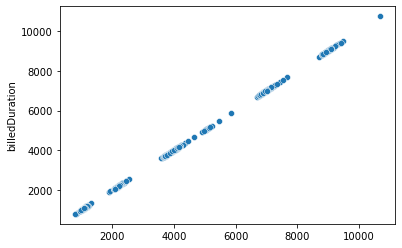

In [264]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

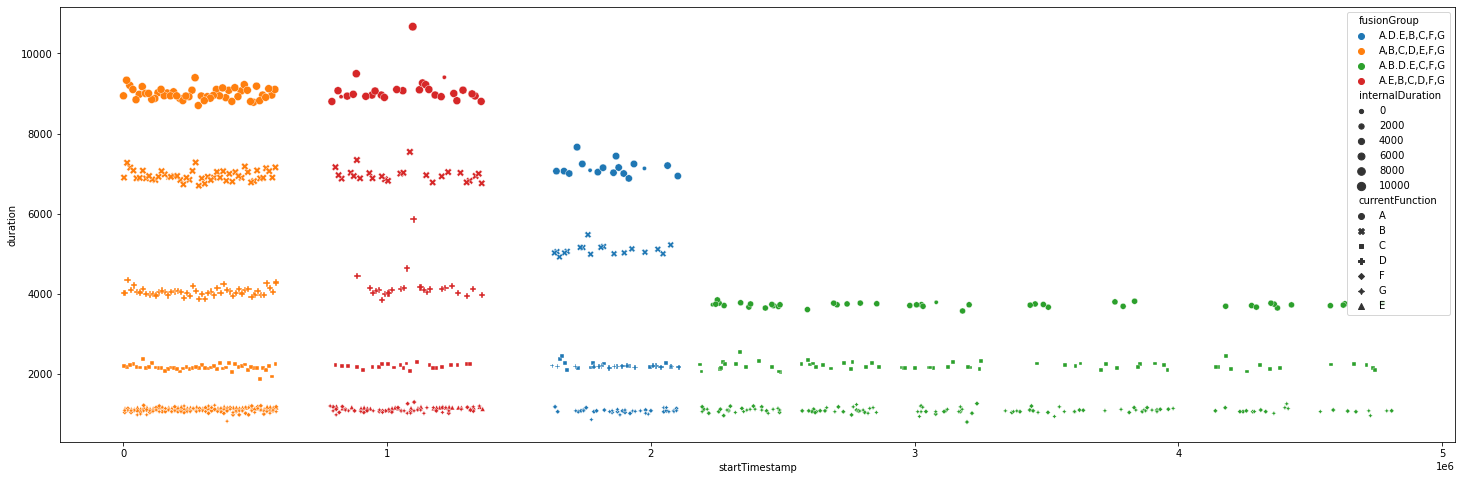

In [265]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="duration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")
plt.savefig("pointCloud.pdf")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

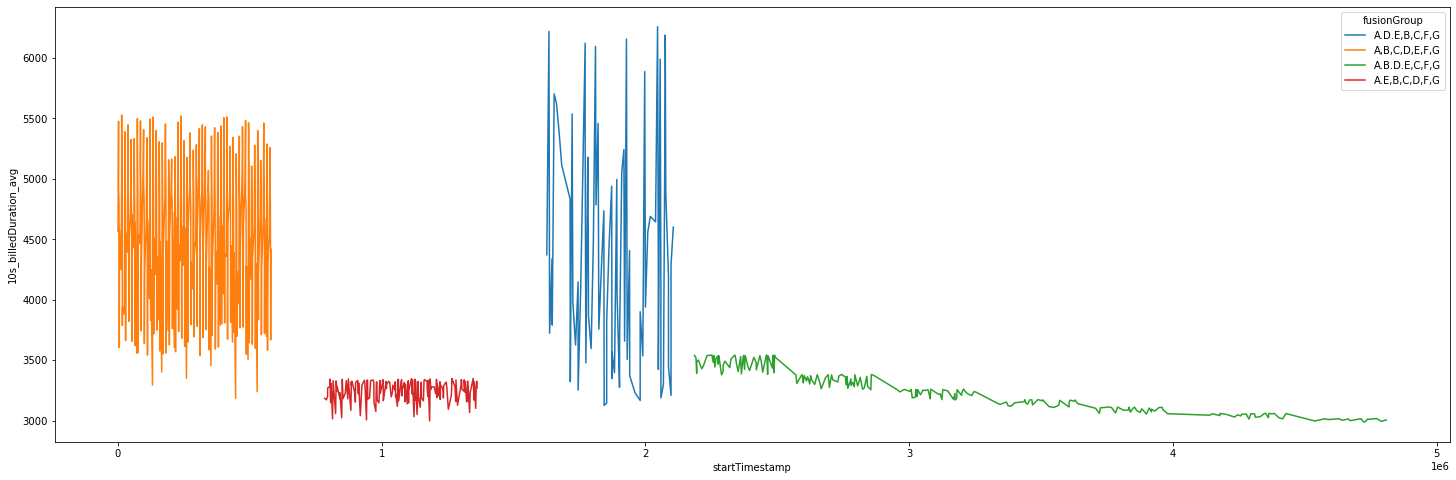

In [266]:
plt.figure(figsize=(25,8))
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
#df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
#sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [267]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

grouped

Total Number of Invocations should be: 856 == 856


/tmp/ipykernel_21038/2807751757.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,002519054edc1268422e31b6db15a8a6d6cd5260dd1185...,956,3530218,3531159,"A.B.D.E,C,F,G",1,NaN,NaN
1,0148195054d405c99edba4b7f3c9cd9ebedf69d86cfa1f...,4924,3438432,3444349,"A.B.D.E,C,F,G",2,3442151.0,3719.0
2,02ce4f7b9458eeb4d354d04cc3dd3e3cc1c9f78332ae0d...,1199,3549002,3550184,"A.B.D.E,C,F,G",1,NaN,NaN
3,031c0245c824f206aaf1806306043fc7ff645fb51870fc...,8291,2063317,2070518,"A.D.E,B,C,F,G",2,2070518.0,7201.0
4,03c8afe3c71762f0a03c485fb44a61303e48b1edfa1a0c...,2147,2965097,2967238,"A.B.D.E,C,F,G",1,NaN,NaN
...,...,...,...,...,...,...,...,...
325,fbf588097d1696137893f83e4875a38ac50e2f2d9377df...,1145,2481875,2483017,"A.B.D.E,C,F,G",1,NaN,NaN
326,fc1acb3d5d1088347f6aeefa8b69ba16f7b86ccff552a4...,23495,1059512,1068584,"A.E,B,C,D,F,G",5,1068582.0,9070.0
327,ff031921077e56dc6eb1b0d42f1f037fedb9faed7e16f7...,7299,1653387,1658308,"A.D.E,B,C,F,G",2,NaN,NaN
328,ff0b3be19fc5a1d37d69fb8f7d0e7402e00b217601a932...,2194,3919180,3920303,"A.B.D.E,C,F,G",2,NaN,NaN


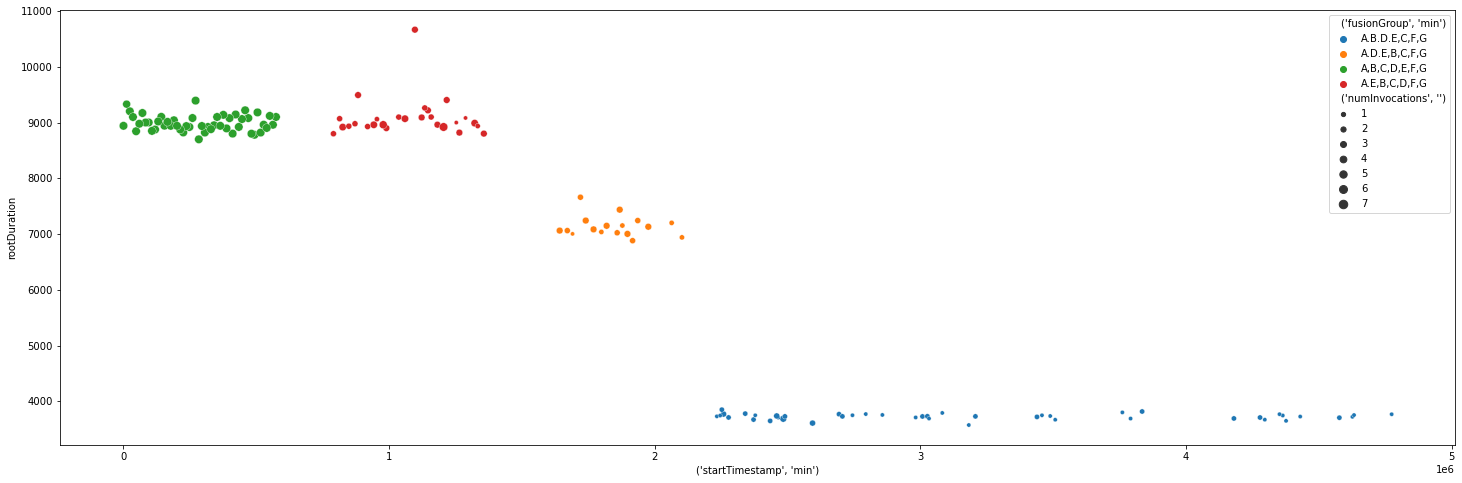

In [268]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("duration.pdf")

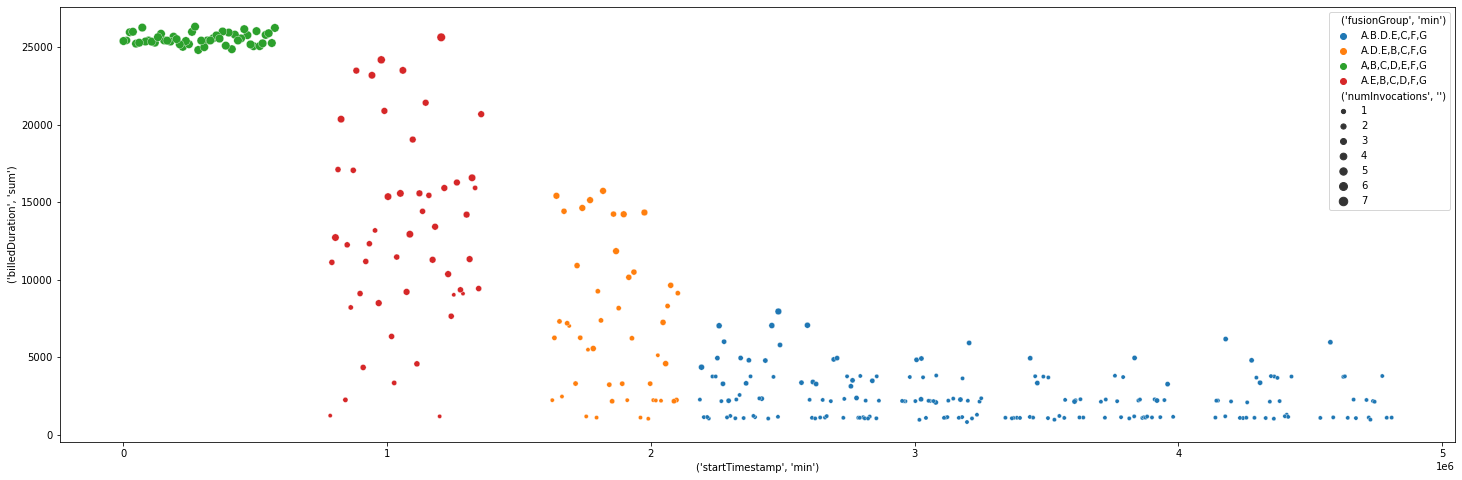

In [269]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("billed.pdf")

['A,B,C,D,E,F,G' 'A.E,B,C,D,F,G' 'A.D.E,B,C,F,G' 'A.B.D.E,C,F,G']


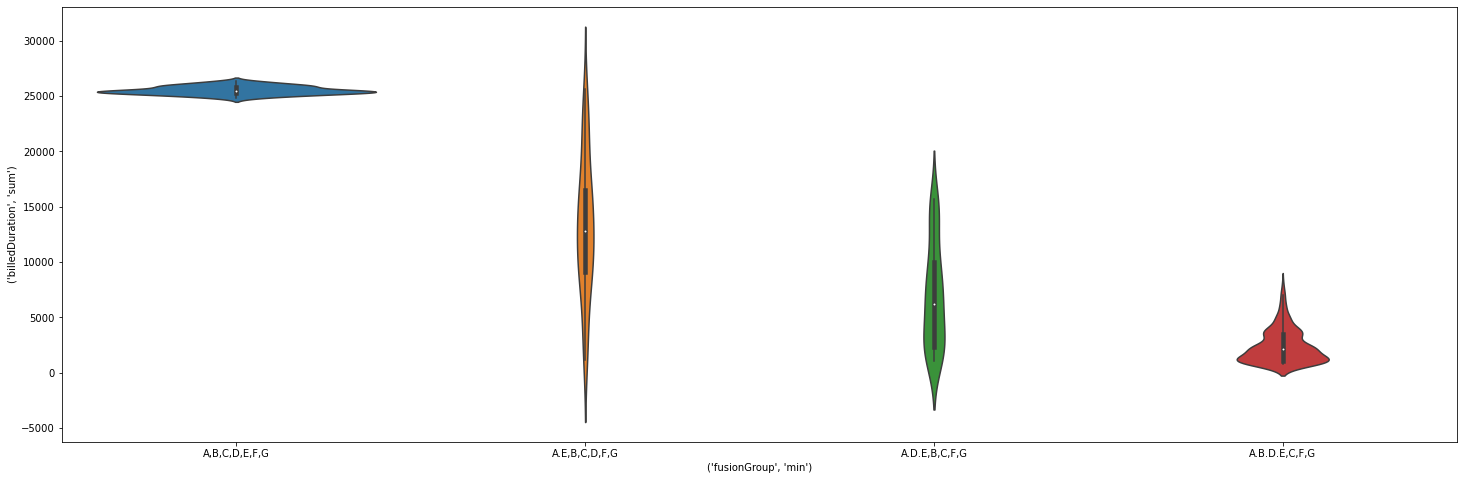

In [270]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['billedDuration', 'sum'], order=fusion_groups_order)
plt.savefig("violinBilled.pdf")

['A,B,C,D,E,F,G' 'A.E,B,C,D,F,G' 'A.D.E,B,C,F,G' 'A.B.D.E,C,F,G']


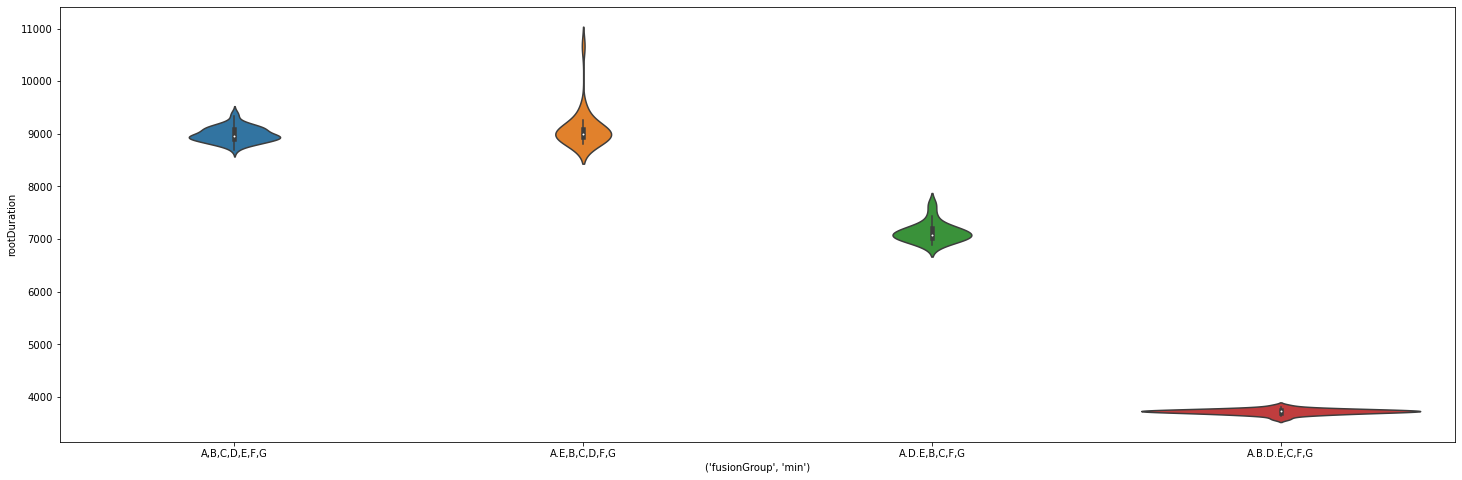

In [271]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['rootDuration'], order=fusion_groups_order)
plt.savefig("violinRR.pdf")